# LSTM Prediction
#### Imports

In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [180]:
#Selecting features and target variable
features = ['consumption', 'temperature', 'consumption_lag_1', 'consumption_lag_2', 'consumption_lag_3', 'time_of_day_Morning', 'time_of_day_Afternoon', 'time_of_day_Evening', 'time_of_day_Night']
location = 'oslo'
specified_date = '2023-01-01 00:00:00'  # replace with specified date

In [181]:
batch_size = 72
epochs = 50

#### Data Cleaning and Feature Engineering

In [182]:
path = r"C:\Users\andre\OneDrive\Documents\AnvendtDS\consumption_temp.csv"
data = pd.read_csv(path)
data['time'] = pd.to_datetime(data['time'])

In [183]:
data_city = data[data['location'] == location].copy()
data_city.sort_values('time', inplace=True)
data_city.reset_index(drop=True, inplace=True)
data_city

,time,location,consumption,temperature
0,2022-04-07 21:00:00,oslo,4.092830,1.0
1,2022-04-07 22:00:00,oslo,3.818095,0.4
2,2022-04-07 23:00:00,oslo,3.660981,0.3
3,2022-04-08 00:00:00,oslo,3.584066,0.2
4,2022-04-08 01:00:00,oslo,3.549536,0.4
...,...,...,...,...
8636,2023-04-02 17:00:00,oslo,12.410225,5.5
8637,2023-04-02 18:00:00,oslo,12.856381,4.8
8638,2023-04-02 19:00:00,oslo,13.010338,0.6
8639,2023-04-02 20:00:00,oslo,12.738356,-0.3


In [184]:
date_index = data_city[data_city['time'] == specified_date].index[0]
train_data_city = data_city.iloc[:date_index-144].copy()
actual_void_data_city = data_city.iloc[date_index-144:date_index+24].copy()
actual_data_city = data_city.iloc[date_index:date_index+24].copy()

In [185]:
train_data_city

,time,location,consumption,temperature
0,2022-04-07 21:00:00,oslo,4.092830,1.0
1,2022-04-07 22:00:00,oslo,3.818095,0.4
2,2022-04-07 23:00:00,oslo,3.660981,0.3
3,2022-04-08 00:00:00,oslo,3.584066,0.2
4,2022-04-08 01:00:00,oslo,3.549536,0.4
...,...,...,...,...
6286,2022-12-25 19:00:00,oslo,14.462347,0.6
6287,2022-12-25 20:00:00,oslo,14.107514,1.1
6288,2022-12-25 21:00:00,oslo,13.643566,1.1
6289,2022-12-25 22:00:00,oslo,13.374302,1.7


In [186]:
# Creating lagged features
n_lags = 3
for lag in range(1, n_lags + 1):
    train_data_city[f'consumption_lag_{lag}'] = train_data_city['consumption'].shift(lag)

# dropping NaN values after lagging and resetting index
train_data_city = train_data_city.dropna().reset_index(drop=True)

In [187]:

# Time of day feature
train_data_city['hour'] = train_data_city['time'].dt.hour
train_data_city['time_of_day'] = pd.cut(train_data_city['hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)
#one-hot encode the time_of_day feature
time_of_day_encoded = pd.get_dummies(train_data_city['time_of_day'], prefix='time_of_day')
train_data_city = pd.concat([train_data_city, time_of_day_encoded], axis=1)


In [188]:
# normalizing data
scaler = MinMaxScaler(feature_range=(0, 1))
data_city_scaled = scaler.fit_transform(train_data_city[features])

In [189]:
train_data_city[features]

,consumption,temperature,consumption_lag_1,consumption_lag_2,consumption_lag_3,time_of_day_Morning,time_of_day_Afternoon,time_of_day_Evening,time_of_day_Night
0,3.584066,0.2,3.660981,3.818095,4.092830,False,False,False,True
1,3.549536,0.4,3.584066,3.660981,3.818095,False,False,False,True
2,3.552738,0.0,3.549536,3.584066,3.660981,False,False,False,True
3,3.638570,-0.4,3.552738,3.549536,3.584066,False,False,False,True
4,3.929940,-0.5,3.638570,3.552738,3.549536,False,False,False,True
...,...,...,...,...,...,...,...,...,...
6283,14.462347,0.6,14.820883,15.102018,15.464832,False,False,True,False
6284,14.107514,1.1,14.462347,14.820883,15.102018,False,False,True,False
6285,13.643566,1.1,14.107514,14.462347,14.820883,False,False,True,False
6286,13.374302,1.7,13.643566,14.107514,14.462347,False,False,True,False


In [190]:
X = data_city_scaled[:, 1:]
y = data_city_scaled[:, 0]

test_size = 0.2  # using 20% of the data for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

#Reshaping [samples, time steps, features] as required for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((5030, 1, 8), (1258, 1, 8), (5030,), (1258,))

#### Model Creation

In [191]:
model = Sequential()
model.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(168)) # 144 hours untill the specified day and a 24 hours prediction

model.compile(loss='mean_squared_error', optimizer='adam')

#### Model Training

In [192]:
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    verbose=2,
    shuffle=False
)

Epoch 1/50


70/70 - 5s - loss: 0.0019 - val_loss: 0.0385 - 5s/epoch - 70ms/step
Epoch 2/50
70/70 - 1s - loss: 0.0094 - val_loss: 0.0995 - 864ms/epoch - 12ms/step
Epoch 3/50
70/70 - 1s - loss: 0.0089 - val_loss: 0.0894 - 783ms/epoch - 11ms/step
Epoch 4/50
70/70 - 1s - loss: 0.0052 - val_loss: 0.0352 - 870ms/epoch - 12ms/step
Epoch 5/50
70/70 - 1s - loss: 0.0031 - val_loss: 0.0076 - 793ms/epoch - 11ms/step
Epoch 6/50
70/70 - 1s - loss: 0.0015 - val_loss: 0.0017 - 925ms/epoch - 13ms/step
Epoch 7/50
70/70 - 1s - loss: 7.1958e-04 - val_loss: 0.0014 - 821ms/epoch - 12ms/step
Epoch 8/50
70/70 - 1s - loss: 4.5055e-04 - val_loss: 0.0016 - 719ms/epoch - 10ms/step
Epoch 9/50
70/70 - 1s - loss: 3.7057e-04 - val_loss: 0.0018 - 755ms/epoch - 11ms/step
Epoch 10/50
70/70 - 1s - loss: 3.4281e-04 - val_loss: 0.0019 - 693ms/epoch - 10ms/step
Epoch 11/50
70/70 - 1s - loss: 3.3133e-04 - val_loss: 0.0019 - 733ms/epoch - 10ms/step
Epoch 12/50
70/70 - 1s - loss: 3.2559e-04 - val_loss: 0.0019 - 978ms/epoch - 14ms/step
Epo

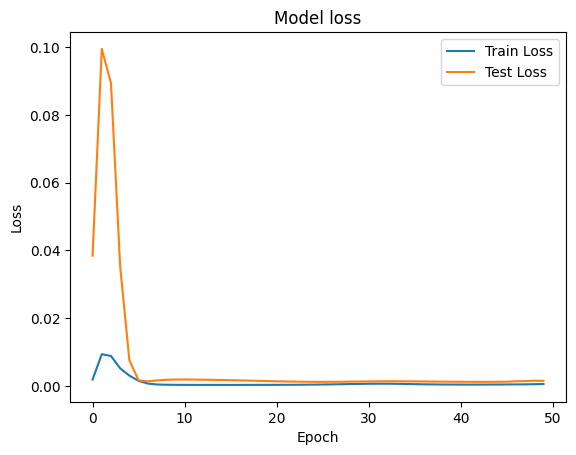

In [193]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

#### Model Prediction

In [194]:
test_predict = model.predict(X_test)

40/40 [==============================] - 2s 10ms/step


In [195]:
# Create dummy matrix with the same shape as original feature matrix
dummy_test = np.zeros((168, len(features)))

# Insert the predicted values into the first column (assuming consumption is the first feature)
dummy_test[:, 0] = pd.DataFrame(test_predict)[0][-168:].values #test_predict[-1]

# Inverse transform using the scaler
test_predict_inv = scaler.inverse_transform(dummy_test)[:, 0]


In [196]:
specified_date_dt = datetime.strptime(specified_date, '%Y-%m-%d %H:%M:%S')
result_date = specified_date_dt - timedelta(hours=144)
result_date_str = result_date.strftime('%Y-%m-%d %H:%M:%S')
dates = pd.date_range(start=result_date_str, periods=168, freq='H')
dates = dates.rename('Date')
test_predict_df = pd.DataFrame(index=dates)
test_predict_df['predicted'] = test_predict_inv
test_predict_df['consumption'] = actual_void_data_city['consumption'].values
test_predict_df

,predicted,consumption
Date,,
2022-12-26 00:00:00,12.983667,12.604906
2022-12-26 01:00:00,12.440193,12.331463
2022-12-26 02:00:00,12.072887,11.948743
2022-12-26 03:00:00,11.845336,11.689323
2022-12-26 04:00:00,11.687774,11.501761
...,...,...
2023-01-01 19:00:00,14.051852,15.685556
2023-01-01 20:00:00,13.777398,15.264776
2023-01-01 21:00:00,13.481678,14.799120


In [197]:
dates = pd.date_range(start=specified_date, periods=24, freq='H')
dates = dates.rename('Date')
actual_data_city['predicted'] = test_predict_inv[-24:]
actual_data_city.set_index('time', inplace=True)
actual_data_city

,location,consumption,temperature,predicted
time,,,,
2023-01-01 00:00:00,oslo,11.608362,-1.7,14.462717
2023-01-01 01:00:00,oslo,11.550801,-1.7,14.321505
2023-01-01 02:00:00,oslo,11.268630,-3.4,14.057673
2023-01-01 03:00:00,oslo,11.227266,-3.1,13.811865
2023-01-01 04:00:00,oslo,11.227632,-4.0,13.634933
2023-01-01 05:00:00,oslo,11.407358,-4.4,13.475872
2023-01-01 06:00:00,oslo,11.596563,-4.1,13.307049
2023-01-01 07:00:00,oslo,11.873966,-4.2,13.332364
2023-01-01 08:00:00,oslo,12.507845,-4.2,13.543610


#### Visualization of Prediction

In [198]:
train_data_city_last24 = train_data_city[-24:].copy()
train_data_city_last24.set_index('time', inplace=True)


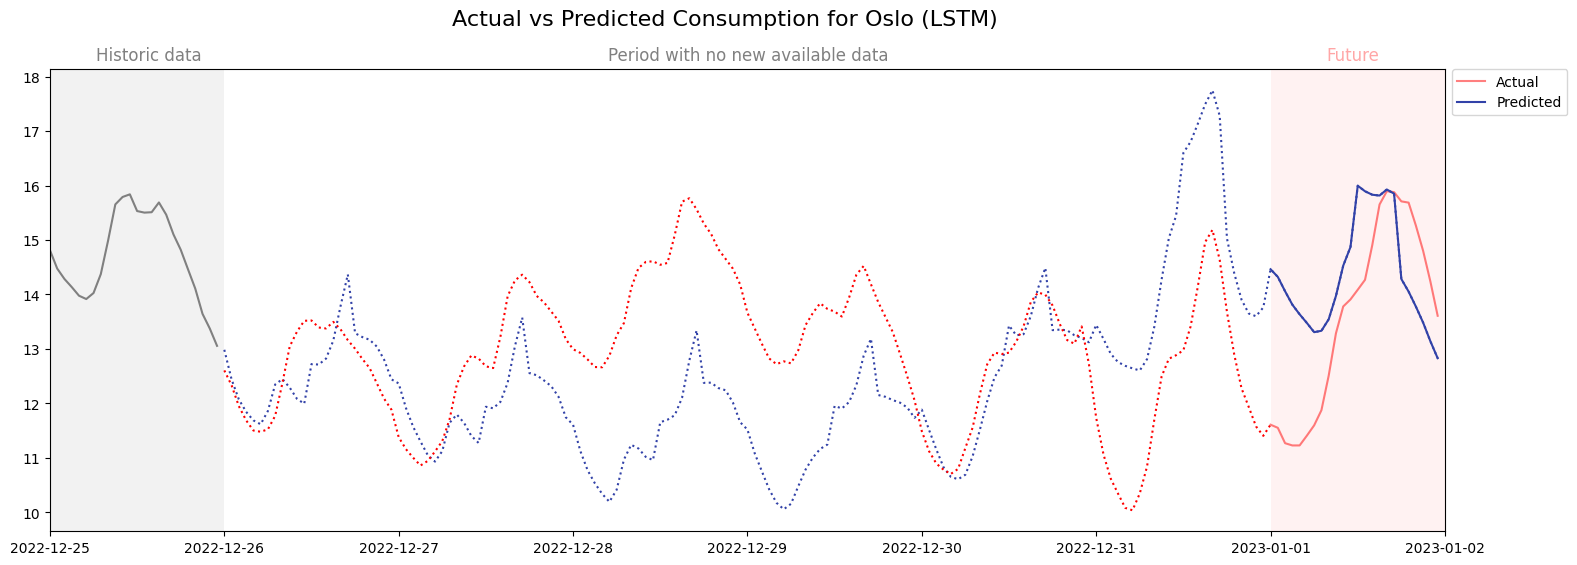

In [199]:
fig, axes = plt.subplots(1, 1, figsize=(18, 6))
axes.plot(actual_data_city['consumption'], label='Actual', color='red', alpha=0.5)
axes.plot(test_predict_df['predicted'], linestyle='dotted', color='#3242a8')#, label='120 hours prediction')
axes.plot(test_predict_df['consumption'][:-23], linestyle='dotted', color='red')
axes.axvspan(specified_date_dt, xmax=specified_date_dt+timedelta(hours=24), facecolor='red', alpha=0.05)
axes.axvspan(specified_date_dt-timedelta(hours=168), xmax=specified_date_dt-timedelta(hours=144), facecolor='black', alpha=0.05)
axes.plot(train_data_city_last24['consumption'], color='grey')#, label='Historic')
axes.plot(actual_data_city['predicted'], label='Predicted', color='#3242a8')
axes.text(0.033, 1.05, 'Historic data', transform=axes.transAxes, fontsize=12, verticalalignment='top', color='grey')
axes.text(0.4, 1.05, 'Period with no new available data', transform=axes.transAxes, fontsize=12, verticalalignment='top', color='grey')
axes.text(0.915, 1.05, 'Future', transform=axes.transAxes, fontsize=12, verticalalignment='top', color='red', alpha=0.35)
axes.set_xlim([specified_date_dt-timedelta(hours=168), specified_date_dt + timedelta(hours=24)])

plt.suptitle(f'Actual vs Predicted Consumption for {location.capitalize()} (LSTM)', fontsize=16)
plt.legend(bbox_to_anchor=(1.005, 1), loc='upper left', borderaxespad=0)
plt.show()


### Benchmark Prediction #1
The previous 144 hours are used as a prediction for the next. The hours each typically behaves similar therefore the prediction won't be too bad and serves as a okay benchmark.

In [200]:
train_data_city # The training data
actual_void_data_city # The void data that is not accessable, but needs to be predicted
actual_data_city # The actual data we want to predict

test_predict_df['benchmark_prediction_1'] = train_data_city[-168:]['consumption'].values
test_predict_df

,predicted,consumption,benchmark_prediction_1
Date,,,
2022-12-26 00:00:00,12.983667,12.604906,12.501766
2022-12-26 01:00:00,12.440193,12.331463,12.204476
2022-12-26 02:00:00,12.072887,11.948743,12.031108
2022-12-26 03:00:00,11.845336,11.689323,11.855375
2022-12-26 04:00:00,11.687774,11.501761,11.876800
...,...,...,...
2023-01-01 19:00:00,14.051852,15.685556,14.462347
2023-01-01 20:00:00,13.777398,15.264776,14.107514
2023-01-01 21:00:00,13.481678,14.799120,13.643566


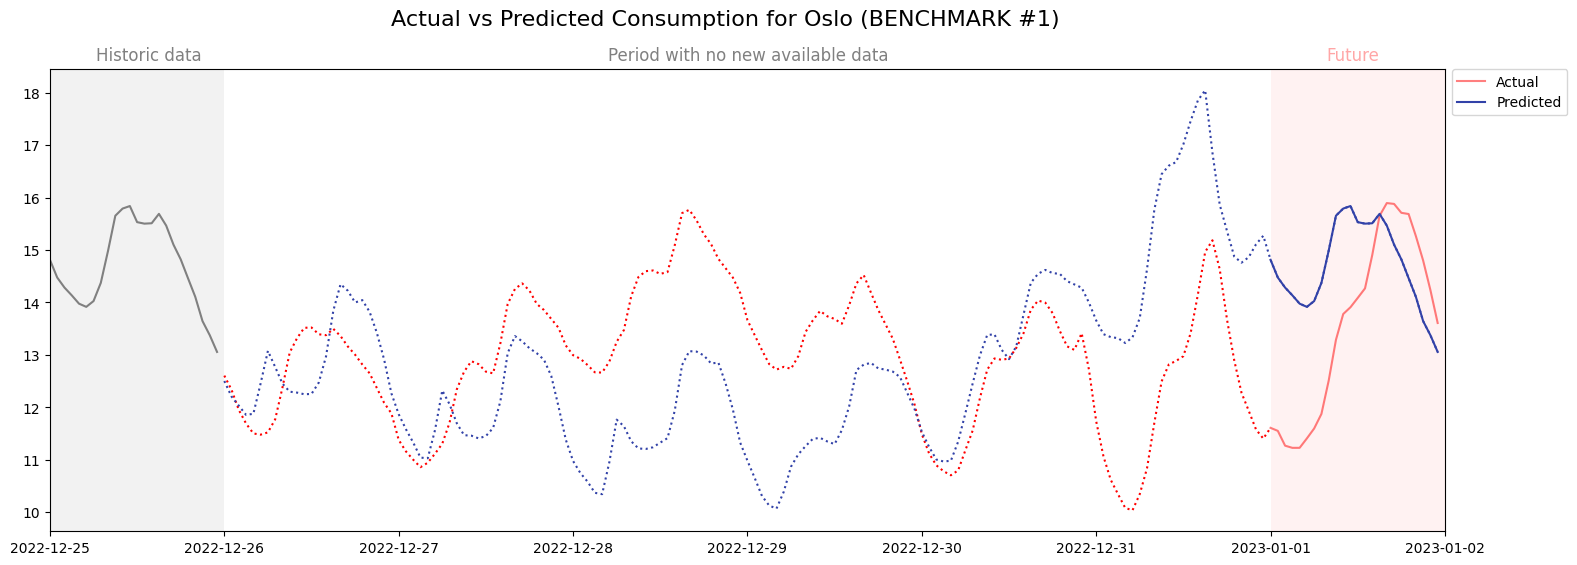

In [201]:
fig, axes = plt.subplots(1, 1, figsize=(18, 6))
axes.plot(actual_data_city['consumption'], label='Actual', color='red', alpha=0.5)
axes.plot(test_predict_df['consumption'][:-23], linestyle='dotted', color='red')
axes.plot(test_predict_df['benchmark_prediction_1'], linestyle='dotted', color='#3242a8')
axes.axvspan(specified_date_dt, xmax=specified_date_dt+timedelta(hours=24), facecolor='red', alpha=0.05)
axes.axvspan(specified_date_dt-timedelta(hours=168), xmax=specified_date_dt-timedelta(hours=144), facecolor='black', alpha=0.05)
axes.plot(train_data_city_last24['consumption'], color='grey')#, label='Historic')
axes.plot(test_predict_df['benchmark_prediction_1'][-24:], label='Predicted', color='#3242a8')
axes.text(0.033, 1.05, 'Historic data', transform=axes.transAxes, fontsize=12, verticalalignment='top', color='grey')
axes.text(0.4, 1.05, 'Period with no new available data', transform=axes.transAxes, fontsize=12, verticalalignment='top', color='grey')
axes.text(0.915, 1.05, 'Future', transform=axes.transAxes, fontsize=12, verticalalignment='top', color='red', alpha=0.35)
axes.set_xlim([specified_date_dt-timedelta(hours=168), specified_date_dt + timedelta(hours=24)])

plt.suptitle(f'Actual vs Predicted Consumption for {location.capitalize()} (BENCHMARK #1)', fontsize=16)
plt.legend(bbox_to_anchor=(1.005, 1), loc='upper left', borderaxespad=0)
plt.show()


In [202]:
train_data_city[features]

,consumption,temperature,consumption_lag_1,consumption_lag_2,consumption_lag_3,time_of_day_Morning,time_of_day_Afternoon,time_of_day_Evening,time_of_day_Night
0,3.584066,0.2,3.660981,3.818095,4.092830,False,False,False,True
1,3.549536,0.4,3.584066,3.660981,3.818095,False,False,False,True
2,3.552738,0.0,3.549536,3.584066,3.660981,False,False,False,True
3,3.638570,-0.4,3.552738,3.549536,3.584066,False,False,False,True
4,3.929940,-0.5,3.638570,3.552738,3.549536,False,False,False,True
...,...,...,...,...,...,...,...,...,...
6283,14.462347,0.6,14.820883,15.102018,15.464832,False,False,True,False
6284,14.107514,1.1,14.462347,14.820883,15.102018,False,False,True,False
6285,13.643566,1.1,14.107514,14.462347,14.820883,False,False,True,False
6286,13.374302,1.7,13.643566,14.107514,14.462347,False,False,True,False


### Better(?) LSTM Prediction
By using the temperatures combined with the predicted void consumption, there may be better results for the 24 hours predicted.

In [203]:
data_city = data[data['location'] == location].copy()
data_city.sort_values('time', inplace=True)
data_city.reset_index(drop=True, inplace=True)
date_index = data_city[data_city['time'] == specified_date].index[0]
train_data_city = data_city.iloc[:date_index-144].copy()
actual_void_data_city = data_city.iloc[date_index-144:date_index+24].copy()

In [204]:
train_data_city

,time,location,consumption,temperature
0,2022-04-07 21:00:00,oslo,4.092830,1.0
1,2022-04-07 22:00:00,oslo,3.818095,0.4
2,2022-04-07 23:00:00,oslo,3.660981,0.3
3,2022-04-08 00:00:00,oslo,3.584066,0.2
4,2022-04-08 01:00:00,oslo,3.549536,0.4
...,...,...,...,...
6286,2022-12-25 19:00:00,oslo,14.462347,0.6
6287,2022-12-25 20:00:00,oslo,14.107514,1.1
6288,2022-12-25 21:00:00,oslo,13.643566,1.1
6289,2022-12-25 22:00:00,oslo,13.374302,1.7


In [205]:
predicted_void_data_city = actual_void_data_city[:144].copy()
predicted_void_data_city['consumption'] = test_predict_df['predicted'][:144].values
predicted_void_data_city

,time,location,consumption,temperature
6291,2022-12-26 00:00:00,oslo,12.983667,1.3
6292,2022-12-26 01:00:00,oslo,12.440193,1.7
6293,2022-12-26 02:00:00,oslo,12.072887,2.1
6294,2022-12-26 03:00:00,oslo,11.845336,2.2
6295,2022-12-26 04:00:00,oslo,11.687774,3.0
...,...,...,...,...
6430,2022-12-31 19:00:00,oslo,14.390565,-1.0
6431,2022-12-31 20:00:00,oslo,13.904071,-2.2
6432,2022-12-31 21:00:00,oslo,13.649542,-2.9
6433,2022-12-31 22:00:00,oslo,13.599728,-2.2


In [206]:
train_data_city_new = pd.concat([train_data_city,predicted_void_data_city])
train_data_city_new

,time,location,consumption,temperature
0,2022-04-07 21:00:00,oslo,4.092830,1.0
1,2022-04-07 22:00:00,oslo,3.818095,0.4
2,2022-04-07 23:00:00,oslo,3.660981,0.3
3,2022-04-08 00:00:00,oslo,3.584066,0.2
4,2022-04-08 01:00:00,oslo,3.549536,0.4
...,...,...,...,...
6430,2022-12-31 19:00:00,oslo,14.390565,-1.0
6431,2022-12-31 20:00:00,oslo,13.904071,-2.2
6432,2022-12-31 21:00:00,oslo,13.649542,-2.9
6433,2022-12-31 22:00:00,oslo,13.599728,-2.2


In [207]:
# Creating lagged features
n_lags = 3
for lag in range(1, n_lags + 1):
    train_data_city_new[f'consumption_lag_{lag}'] = train_data_city_new['consumption'].shift(lag)

# dropping NaN values after lagging and resetting index
train_data_city_new = train_data_city_new.dropna().reset_index(drop=True)

# Time of day feature
train_data_city_new['hour'] = train_data_city_new['time'].dt.hour
train_data_city_new['time_of_day'] = pd.cut(train_data_city_new['hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)
#one-hot encode the time_of_day feature
time_of_day_encoded = pd.get_dummies(train_data_city_new['time_of_day'], prefix='time_of_day')
train_data_city_new = pd.concat([train_data_city_new, time_of_day_encoded], axis=1)

# normalizing data
scaler = MinMaxScaler(feature_range=(0, 1))
data_city_scaled_new = scaler.fit_transform(train_data_city_new[features])

X = data_city_scaled_new[:, 1:]
y = data_city_scaled_new[:, 0]

test_size = 0.2  # using 20% of the data for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

#Reshaping [samples, time steps, features] as required for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

model = Sequential()
model.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(24)) # A 24 hours prediction

model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=72,
    validation_data=(X_test, y_test),
    verbose=2,
    shuffle=False
)

Epoch 1/50
72/72 - 5s - loss: 0.0019 - val_loss: 0.0356 - 5s/epoch - 68ms/step
Epoch 2/50
72/72 - 1s - loss: 0.0079 - val_loss: 0.0568 - 730ms/epoch - 10ms/step
Epoch 3/50
72/72 - 1s - loss: 0.0096 - val_loss: 0.0573 - 766ms/epoch - 11ms/step
Epoch 4/50
72/72 - 1s - loss: 0.0054 - val_loss: 0.0160 - 796ms/epoch - 11ms/step
Epoch 5/50
72/72 - 1s - loss: 0.0028 - val_loss: 0.0023 - 769ms/epoch - 11ms/step
Epoch 6/50
72/72 - 1s - loss: 0.0012 - val_loss: 0.0013 - 649ms/epoch - 9ms/step
Epoch 7/50
72/72 - 1s - loss: 6.0070e-04 - val_loss: 0.0016 - 634ms/epoch - 9ms/step
Epoch 8/50
72/72 - 1s - loss: 4.3184e-04 - val_loss: 0.0018 - 762ms/epoch - 11ms/step
Epoch 9/50
72/72 - 1s - loss: 3.7775e-04 - val_loss: 0.0019 - 723ms/epoch - 10ms/step
Epoch 10/50
72/72 - 1s - loss: 3.5708e-04 - val_loss: 0.0019 - 714ms/epoch - 10ms/step
Epoch 11/50
72/72 - 1s - loss: 3.4777e-04 - val_loss: 0.0019 - 694ms/epoch - 10ms/step
Epoch 12/50
72/72 - 1s - loss: 3.4319e-04 - val_loss: 0.0018 - 750ms/epoch - 10ms

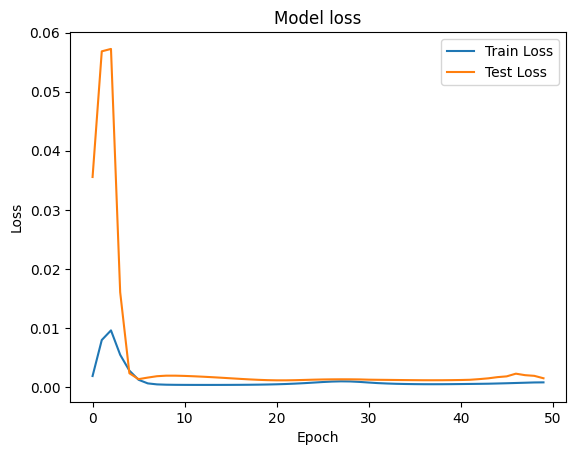

In [208]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [209]:
test_predict = model.predict(X_test)

# Create dummy matrix with the same shape as original feature matrix
dummy_test = np.zeros((24, len(features)))

# Insert the predicted values into the first column (assuming consumption is the first feature)
dummy_test[:, 0] = pd.DataFrame(test_predict)[0][-24:].values #test_predict[-1]

# Inverse transform using the scaler
test_predict_inv = scaler.inverse_transform(dummy_test)[:, 0]

specified_date_dt = datetime.strptime(specified_date, '%Y-%m-%d %H:%M:%S')
result_date = specified_date_dt
result_date_str = result_date.strftime('%Y-%m-%d %H:%M:%S')
dates = pd.date_range(start=result_date_str, periods=24, freq='H')
dates = dates.rename('Date')
test_predict_new_df = pd.DataFrame(index=dates)
test_predict_new_df['predicted'] = test_predict_inv
test_predict_df['predicted_better'] = list(predicted_void_data_city['consumption'].values) + list(test_predict_new_df['predicted'].values)


41/41 [==============================] - 1s 3ms/step


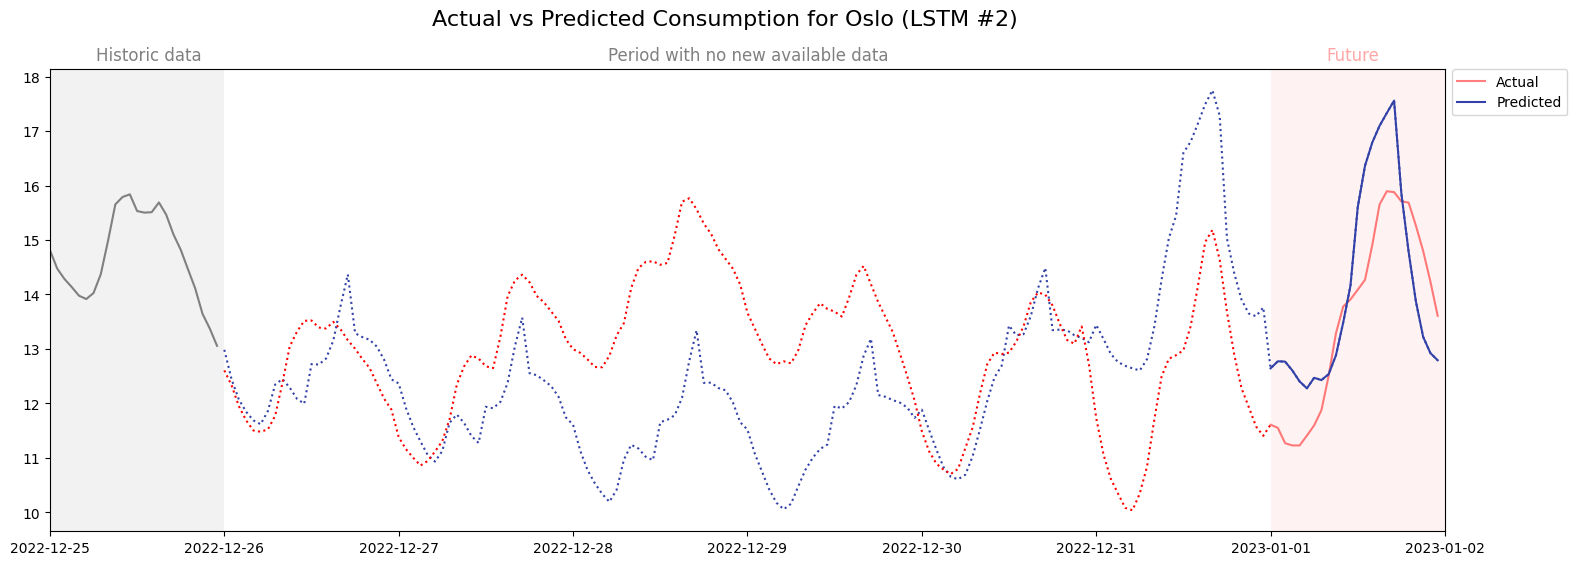

In [210]:
fig, axes = plt.subplots(1, 1, figsize=(18, 6))
axes.plot(actual_data_city['consumption'], label='Actual', color='red', alpha=0.5)
#axes.plot(test_predict_df['predicted'], linestyle='dotted', color='grey')#, label='120 hours prediction')
axes.plot(test_predict_df['predicted_better'], linestyle='dotted', color='#3242a8')
axes.plot(test_predict_df['consumption'][:-23], linestyle='dotted', color='red')
axes.axvspan(specified_date_dt, xmax=specified_date_dt+timedelta(hours=24), facecolor='red', alpha=0.05)
axes.axvspan(specified_date_dt-timedelta(hours=168), xmax=specified_date_dt-timedelta(hours=144), facecolor='black', alpha=0.05)
axes.plot(train_data_city_last24['consumption'], color='grey')#, label='Historic')
#axes.plot(actual_data_city['consumption'], label='Predicted', color='grey')
axes.plot(test_predict_df['predicted_better'][-24:], label='Predicted', color='#3242a8')
axes.text(0.033, 1.05, 'Historic data', transform=axes.transAxes, fontsize=12, verticalalignment='top', color='grey')
axes.text(0.4, 1.05, 'Period with no new available data', transform=axes.transAxes, fontsize=12, verticalalignment='top', color='grey')
axes.text(0.915, 1.05, 'Future', transform=axes.transAxes, fontsize=12, verticalalignment='top', color='red', alpha=0.35)
axes.set_xlim([specified_date_dt-timedelta(hours=168), specified_date_dt + timedelta(hours=24)])

plt.suptitle(f'Actual vs Predicted Consumption for {location.capitalize()} (LSTM #2)', fontsize=16)
plt.legend(bbox_to_anchor=(1.005, 1), loc='upper left', borderaxespad=0)
plt.show()


### Evaluation Metrics

In [211]:
final_predictions = test_predict_df[-24:]
final_predictions

,predicted,consumption,benchmark_prediction_1,predicted_better
Date,,,,
2023-01-01 00:00:00,14.462717,11.608362,14.812319,12.643051
2023-01-01 01:00:00,14.321505,11.550801,14.474798,12.772343
2023-01-01 02:00:00,14.057673,11.268630,14.283333,12.766222
2023-01-01 03:00:00,13.811865,11.227266,14.135328,12.603099
2023-01-01 04:00:00,13.634933,11.227632,13.976476,12.402021
2023-01-01 05:00:00,13.475872,11.407358,13.915316,12.275818
2023-01-01 06:00:00,13.307049,11.596563,14.025825,12.469396
2023-01-01 07:00:00,13.332364,11.873966,14.372773,12.427226
2023-01-01 08:00:00,13.543610,12.507845,14.986397,12.536832


In [212]:
y_true = final_predictions['consumption']
y_pred_benchmark = final_predictions['benchmark_prediction_1']
y_pred_better = final_predictions['predicted_better']
y_pred = final_predictions['predicted']

mae_better = mean_absolute_error(y_true, y_pred_better)
mse_better = mean_squared_error(y_true, y_pred_better)
rmse_better = mean_squared_error(y_true, y_pred_better, squared=False)  # if squared=False, this is RMSE
r2_better = r2_score(y_true, y_pred_better)

mae_benchmark = mean_absolute_error(y_true, y_pred_benchmark)
mse_benchmark = mean_squared_error(y_true, y_pred_benchmark)
rmse_benchmark = mean_squared_error(y_true, y_pred_benchmark, squared=False)
r2_benchmark = r2_score(y_true, y_pred_benchmark)

mae_pred = mean_absolute_error(y_true, y_pred)
mse_pred = mean_squared_error(y_true, y_pred)
rmse_pred = mean_squared_error(y_true, y_pred, squared=False)
r2_pred = r2_score(y_true, y_pred)

print("\nMetrics for Benchmark #1:")
print(f"MAE: {mae_benchmark}")
print(f"MSE: {mse_benchmark}")
print(f"RMSE: {rmse_benchmark}")
print(f"R-squared: {r2_benchmark}")

print("\nMetrics for LSTM:")
print(f"MAE: {mae_pred}")
print(f"MSE: {mse_pred}")
print(f"RMSE: {rmse_pred}")
print(f"R-squared: {r2_pred}")

print("\nMetrics for LSTM #2:")
print(f"MAE: {mae_better}")
print(f"MSE: {mse_better}")
print(f"RMSE: {rmse_better}")
print(f"R-squared: {r2_better}")



Metrics for Benchmark #1:
MAE: 1.724273291666666
MSE: 3.8594100138962055
RMSE: 1.9645381171909608
R-squared: -0.35253931692729057

Metrics for LSTM:
MAE: 1.4375402557267585
MSE: 2.753037655760257
RMSE: 1.6592280300670723
R-squared: 0.03519147823374302

Metrics for LSTM #2:
MAE: 1.0744363548584692
MSE: 1.4614741269295664
RMSE: 1.2089144415257709
R-squared: 0.48782295474517956


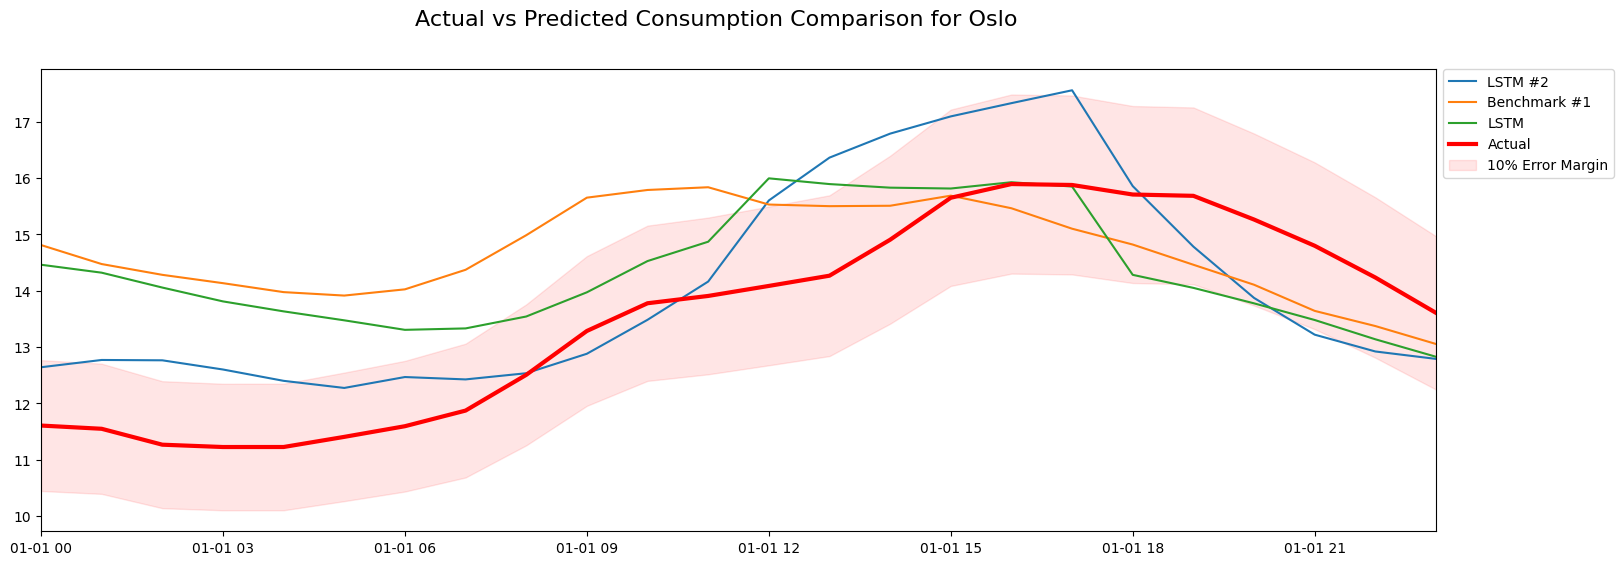

In [213]:
fig, axes = plt.subplots(1, 1, figsize=(18, 6))

axes.plot(test_predict_df['predicted_better'][-24:], label='LSTM #2')
axes.plot(test_predict_df['benchmark_prediction_1'][-24:], label='Benchmark #1')
axes.plot(actual_data_city['predicted'][-24:], label='LSTM')

axes.plot(actual_data_city['consumption'][-24:], label='Actual', color='red', linewidth=3)

upper_bound = actual_data_city['consumption'] * 1.10
lower_bound = actual_data_city['consumption'] * 0.90

axes.fill_between(actual_data_city.index[-24:], lower_bound[-24:], upper_bound[-24:], color='red', alpha=0.1, label='10% Error Margin')

axes.set_xlim([specified_date_dt, specified_date_dt + timedelta(hours=23)])

plt.suptitle(f'Actual vs Predicted Consumption Comparison for {location.capitalize()}', fontsize=16)
plt.legend(bbox_to_anchor=(1.005, 1), loc='upper left', borderaxespad=0)
plt.show()